### GD-VAE: Manifold Map (Klein Bottle)
[http://atzberger.org](http://atzberger.org)

#### Overview

Demonstrates how to create a manifold mapping layer for use with neural network models and backpropogation training methods.

In [1]:
import torch,os,sys,pickle,time,shutil,logging,numpy as np,matplotlib,matplotlib.pyplot as plt;
import gd_vae_pytorch; import gd_vae_pytorch.nn; import gd_vae_pytorch.utils; import gd_vae_pytorch.vae; 
import gd_vae_pytorch.geo_map; import gd_vae_pytorch.log; gd_vae = gd_vae_pytorch;

# local packages
sys.path.insert(1,'.');
import pkg,pkg.utils as utils;
import pkg.geometry as geometry;
import pkg.vis as vis;

# script name without extension
script_base_name = 'map_pointcloud_klein1'; 

In [2]:
# run name and output directory 
run_name = 'test_0001';
base_dir  = './output/%s/%s'%(script_base_name,run_name);

# configure the device(s) to use
if torch.cuda.is_available():  
  num_gpus = torch.cuda.device_count();
  print("num_gpus = " + str(num_gpus));
  if num_gpus >= 4:
    device = torch.device('cuda:2');
  else:
    device = torch.device('cuda:0');
else: 
  device = torch.device('cpu');

print("device = " + str(device));
print("base_dir = " + str(base_dir));


num_gpus = 1
device = cuda:0
base_dir = ./output/map_pointcloud_klein1/test_0001


In [3]:
params_map = {};
params_map.update({'device':device});

params_klein = {};
params_klein.update({'a':5,'b':8,'n1':120,'n2':120,'device':device});
params_map.update({'params_klein':params_klein});

# setup manifold description as point cloud
x,u = geometry.sample_klein_bottle_points_R4(params_klein);
num_samples = x.shape[0]; num_dim_x = x.shape[1]; num_dim_u = u.shape[1];
manifold_chart_I = torch.zeros(num_samples,device=device);
manifold_chart_u = torch.zeros(num_samples,num_dim_u,device=device);
manifold_ptsX = torch.zeros(num_samples,num_dim_x,device=device);

# chart 0: (only one chart for now)
chart_I = 0; I = torch.arange(0,num_samples);
manifold_chart_I[I] = chart_I;
manifold_chart_u[I,:] = u[I,:];
manifold_ptsX[I,:] = x[I,:];

# setup manifold mappings
params_map.update({'manifold_chart_I':manifold_chart_I});
params_map.update({'manifold_chart_u':manifold_chart_u});
params_map.update({'manifold_ptsX':manifold_ptsX});

params_map.update({'find_nearest_manifold_pt':
                   gd_vae.geo_map.PointCloudMapFunc.find_nearest_manifold_pt_kdtree
                  });
params_map.update({'find_nearest_manifold_pt_params':{'kdtree_params':
                                                      {'leaf_size':10,'metric':'euclidean'},
                                                      'manifold_ptsX':manifold_ptsX
                                                     }
                  });
params_map.update({'get_manifold_sigma_info':geometry.get_manifold_sigma_info_klein1});
params_map.update({'get_manifold_sigma_info_params':{'manifold_chart_I':manifold_chart_I,
                                                     'manifold_chart_u':manifold_chart_u,
                                                     'manifold_ptsX':manifold_ptsX,
                                                     'params_klein':params_klein,
                                                     'device':device}});

manifold_map = gd_vae.geo_map.ManifoldPointCloudLayer(params_map); # can be used as part of PyTorch pipeline with backprop


In [4]:
# demonstrate the mapping 
flag_run_cell = True;
if flag_run_cell:        
    #theta = np.linspace(0,2*np.pi,100);
    theta = np.linspace(0,2*np.pi,100);
    r_theta = 35.0 + 4.0*np.sin(4*theta);
    X = np.array([r_theta*np.sin(theta),r_theta*np.cos(theta),1.0 + 0*r_theta,1.0 + 0*r_theta]).T;
    X = 0.1*X;
    X = torch.from_numpy(X).to(device);

    # -- compute the mapping
    X.requires_grad = True;
    x_star = manifold_map.forward(X);
    #x_star = manifold_map.apply(X);

    # -- compute gradient of loss function
    loss = torch.sum(x_star); # as a test
    loss.backward();
    loss_grad_X = X._grad;

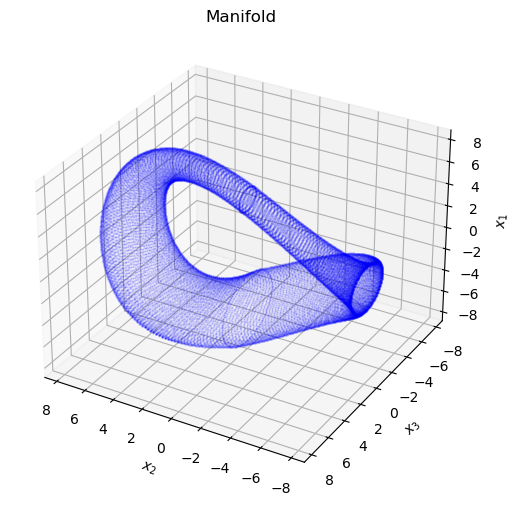

In [5]:
# plot the Klein bottle immersion in R^3
L = 8.5;
vis.plot_klein_R3_immersion(params_klein,ax_view=(30,120),skip_factor=1,vec_x_lim=[(-L,L),(-L,L),(-L,L)],alpha=0.1,ms=1.5);